In [1]:
import numpy as np
#import mpmath
from scipy.integrate import solve_bvp
from scipy.optimize import root, minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

### Demo on using root_finder to solve constrained ODE system
ODE: y" + 3y' - ny = 0, y(0) = 1, y(1) = 0, n = 4

Constraint: (1-exp(5))y'(1/2) - 2n - sqrt(e)= 4exp(3) - 8 

In [52]:
x = np.linspace(0, 1, 100)
initial_guess = np.ones((2, x.size), dtype=np.float64)

### 2nd order ODE
def fun(x, y, n):
    return np.vstack((y[1], -3*y[1] + n*y[0]))

### boundary condition y(0)=1, y(1)=0
def bc(ya, yb):
    return np.array([ya[0]-1, yb[0]])

### solve the ODE in each region for a given n
def solve_ode_for_n(n):
    sol = solve_bvp(lambda x, y: fun(x, y, n), bc, x, initial_guess)
    if sol.success:
        return sol
    else:
        raise ValueError("ODE solver failed to converge for n = {}".format(n))

### analytic result by Wolfram Alpha
def ana(x):
    return (np.exp(-4*x)*(np.exp(5)-np.exp(5*x)))/(np.exp(5)-1)

# Function that relates y'(x) and n
def relation_between_y_and_n(yp_val, x, n):
    yp = interp1d(x, yp_val)
    return np.abs((1-np.exp(5))*yp(1/2) - np.sqrt(np.e) - 4*np.exp(3) + 8 - 2*n)[0]

# Wrapper function to find the root (i.e., find n)
def find_n(x):
    def root_function(n):
        solution = solve_ode_for_n(n)
        yp_values = solution.sol(x)[1]
        return relation_between_y_and_n(yp_values, x, n)
    
    guess = np.array([1]) # Initial guess for n
    n_solution = minimize(root_function, guess, tol=1e-5, method='BFGS')
    
    return n_solution.x

# Find n that satisfies the relation
n_final = find_n(x)[0]
print('n truth:', 4)
print('n result:', n_final)

# Solve the ODE with the found n
final_solution = solve_ode_for_n(n_final)

# Extract the solution
y_values = final_solution.sol(x)[0]  # u(r) is the first component of the solution

n truth: 4
n result: 4.029933963035946


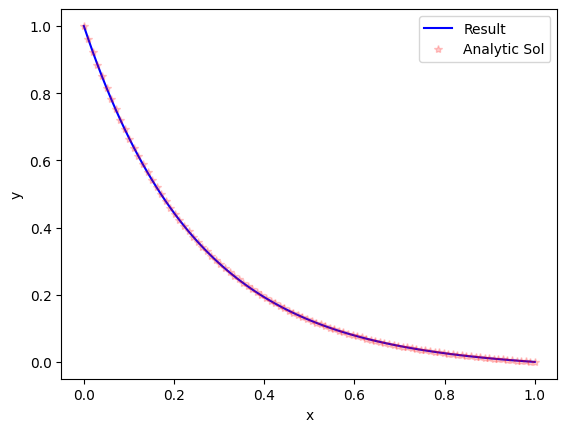

In [53]:
plt.plot(x, y_values, 'b-', label='Result')
plt.plot(x, ana(x), 'r*', alpha=0.2, label='Analytic Sol')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Demo on using MCMC to solve constrained ODE system

41054it [08:24, 81.39it/s, batch: 1 | bound: 3 | nc: 1 | ncall: 705203 | eff(%):  5.297 | loglstar: -1.174 < -0.000 < -0.170 | logz: -6.112 +/-  0.045 | stop:  0.617]                


n real =  0.43 +/-  8.24, maxL_param =  4.16


(<Figure size 340x340 with 1 Axes>,
 array([[<Axes: title={'center': 'n real = ${3.86}_{-22.50}^{+0.33}$'}, xlabel='n real'>]],
       dtype=object))

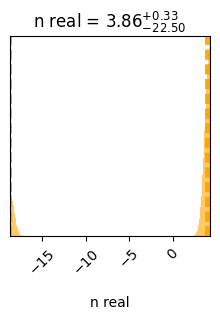

In [54]:
# Log-likelihood function
def log_likelihood(n):
    solution = solve_ode_for_n(n)
    yp_values = solution.sol(x)[1]
    g_n = relation_between_y_and_n(yp_values, x, n)
    log_l = -0.5 * np.log(g_n)**2 / sigma**2
    return log_l

# Prior transform function (Uniform prior for n)
def prior_transform(n):
    n_min = -20.0  # minimum value for n
    n_max = 20.0  # maximum value for n
    n = n_min + (n_max - n_min)*n
    return n

# Parameters and initial conditions
x = np.linspace(0, 1, 100)
initial_guess = np.ones((2, x.size), dtype=np.float64)
sigma = 0.1  # noise level in likelihood

# Set up the dynesty sampler
sampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim=1, bound='multi', nlive=3000, sample='rslice', bootstrap=None)

# Run the nested sampling
sampler.run_nested()

# Get the results
results = sampler.results

# Analyze results
samples = results.samples
# normalized weights
weights = np.exp(results.logwt - results.logz[-1])
# resample weighted samples with equal weights
samples_equal = dyfunc.resample_equal(samples, weights)
# results.summary()
# compute weighted mean and covariance
mean, cov = dyfunc.mean_and_cov(samples, weights)
errors = np.diagonal(cov)**0.5
maxL_index = results['logl'].argmax()
maxL_params = samples[maxL_index]
param_names = ['n real', 'n imag']
labels = ['n real', 'n imag']

title_quantiles = [0.16, 0.5, 0.84]
for ii in range(len(mean)):
    print('{0:5s} = {1:5.2f} +/- {2:5.2f}, maxL_param = {3:5.2f}'.format(param_names[ii],
                                                      mean[ii], errors[ii], maxL_params[ii]))
plt.close('all')
dyplot.runplot(results)
plt.close()
#plt.savefig(‘/Users/xuningyuan/Galactic_Center_YNC/eccentricity_dist/dnest_ecc_run_’ + suffix + ‘.png’)
dyplot.traceplot(results, labels=labels)
plt.close()
#plt.savefig(‘/Users/xuningyuan/Galactic_Center_YNC/eccentricity_dist/dnest_ecc_trace_’ + suffix + ‘.png’)
dyplot.cornerplot(results, labels=labels, color='orange', truth_color='blue', show_titles=True)
#plt.savefig(‘figures/corner_Ma-0.5_i70.png’, dpi=300, bbox_inches=‘tight’)